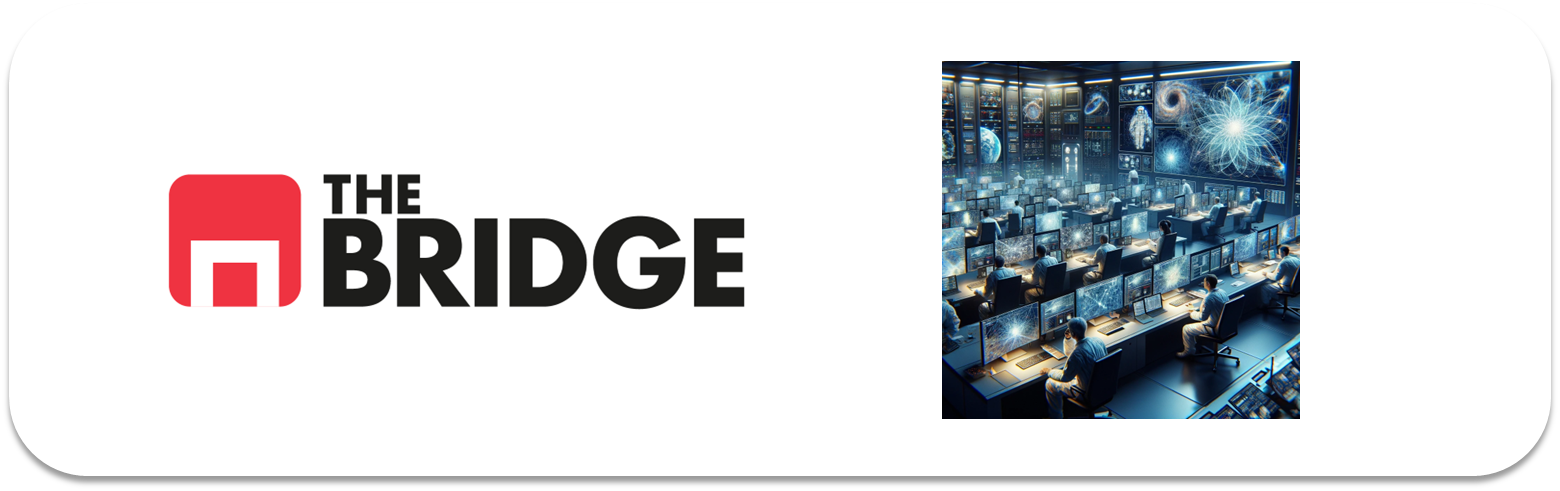

## PRACTICA OBLIGATORIA: **Transfer Learning y Fine Tuning**

* La práctica obligatoria de esta unidad consiste en un repetir el ejercicio de construcción de un modelo de clasificación de paisajes pero usando un modelo preentrenado. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook.

In [24]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

from skimage.io import imread
from sklearn.utils import shuffle
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils import shuffle

import tensorflow as tf

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

from tensorflow.keras.applications import ResNet50V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout

# ignore warnings
import warnings
warnings.filterwarnings("ignore")

### Objetivo del ejercicio

Comparar una red convolucional hecha ad-hoc frente a los modelos preentrenados y ajustados con fine tuning y transfer learning. Para ello emplea el dataset de paisajes del conjunto de ejercicios de la unidad anterior.


### Se pide

1. Preparar los datos del modelo y las funciones de visualización, copia para ello todo lo que necesites de las soluciones del ejercicio de clasificación de paisajes de la unidad anterior.

2. Escoger entre uno de los modelos VGG-19, InceptionV3 y MobileNetV2 (todos en https://keras.io/api/applications/) (Se aconseja este último si no tenemos un ordenador muy potente). Si no te haces con estos puedes recurrir a la ResNetV50.

4. Hacer un transfer-learning con una cabeza de como mucho 2 capas densas ocultas y una de salida. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

5. Hacer un fine-tuning con la misma cabeza diseñada en el punto anterior. Mostrar la evaluación contra test, el report de clasificación y la matriz de confusión.

6. Comparar los resultados con los obtenidos con la red convolucional del ejercicio mencionado.

EXTRA:
- Repetir el transfer learning empleando aumentado de imágenes.



## 1 Parte

In [2]:
ROOT_PATH = './data/'
TRAIN_PATH = ROOT_PATH + "seg_train"
TEST_PATH = ROOT_PATH + "seg_test"

In [3]:
def load_data(directorio, reshape_dim = (32,32)):
    X = [] 
    y = []
    for folder in os.listdir(directorio):
        print(folder)
        if os.path.isdir('/'.join([directorio, folder])):
            for file in os.listdir('/'.join([directorio, folder])):

                image = imread('/'.join([directorio, folder, file]))
                image = cv2.resize(image, reshape_dim) # Redimensionamos a 32x32

                X.append(image)
                y.append(folder)

    return np.array(X),np.array(y)

In [4]:
X_train,y_train = load_data(TRAIN_PATH)
X_test, y_test = load_data(TEST_PATH)

buildings
forest
glacier
mountain
sea
street
buildings
forest
glacier
mountain
sea
street


In [6]:
print('X train shape: ', X_train.shape)
print('Y train shape: ', y_train.shape)

X train shape:  (14034, 32, 32, 3)
Y train shape:  (14034,)


*14034 imagenes de 32x32 con 3 canales para los colores en el train*

In [7]:
print('X train shape: ', X_test.shape)
print('Y train shape: ', y_test.shape)

X train shape:  (3000, 32, 32, 3)
Y train shape:  (3000,)


*3000 imagenes en el test*

In [8]:
def show_images_batch(paisajes, names = [], n_cols = 5, size_scale = 2):
    n_rows = ((len(paisajes) - 1) // n_cols + 1)
    plt.figure(figsize=(n_cols * size_scale, n_rows * 1.1*size_scale))
    for index, paisaje in enumerate(paisajes):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(paisaje, cmap = "Greys")
        plt.axis("off")
        if len(names):
            plt.title(names[index])

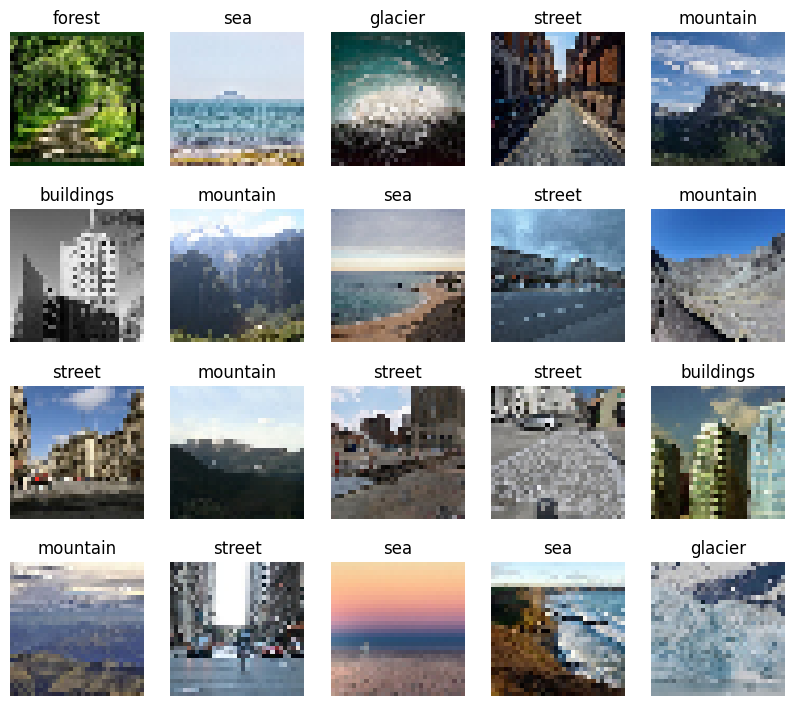

In [9]:
# muestra de las imagenes
indices = np.random.randint(0,len(X_train),20)
show_images_batch(X_train[indices], names = y_train[indices], n_cols = 5)

In [10]:
# Minidieda
targets = pd.Series(y_train)
targets.value_counts(True)

mountain     0.178994
glacier      0.171298
street       0.169731
sea          0.162035
forest       0.161821
buildings    0.156121
Name: proportion, dtype: float64

Tenemos los datos balanceados en nuestras 6 clases

## 2 Parte

In [11]:
# Escalamos
X_train = X_train/255
X_test = X_test/255

In [12]:
# mapeado de las clases
map={'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

inv_map={0: 'buildings',
 1: 'forest',
 2: 'glacier',
 3: 'mountain',
 4: 'sea',
 5: 'street'}

In [13]:
y_train_num = np.array([map[i] for i in y_train])
y_test_num = np.array([map[i] for i in y_test])

In [36]:
# Aleatorizamos los datos
X_train, y_train = shuffle(X_train, y_train_num, random_state=42)

Hago mi modelo con ResNet50V2

In [37]:
shape=X_train[0].shape
shape

(32, 32, 3)

In [19]:
#modelo
# todo por defecto menos input_shape que es la establecida, e include_top que es false ( whether to include the fully-connected layer at the top of the network.)

base_model=ResNet50V2(
    include_top=False,
    weights="imagenet",
    input_tensor=None,
    input_shape=shape,
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)

In [20]:
base_model.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 18, 18, 64)           0         ['conv1_conv[0][0]']          
                                                                                         

## 3 Parte

In [21]:
# Congelar las capas del modelo para que los pesos no cambien
for layer in base_model.layers:
    layer.trainable = False

In [26]:
# Fully connected layer

x = layers.Flatten()(base_model.output)
x = layers.Dense(units=512, activation='relu')(x)
x = layers.Dropout(0.25)(x)
x = layers.Dense(units=128, activation='relu')(x)
output = layers.Dense(6, activation='softmax')(x)

In [27]:
# modelo con transfer learning:

model=Model(base_model.input,x)

In [28]:
# optimizador para clasificador multiclase
model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = 'accuracy')

In [29]:
# vemos las capas
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 32, 32, 3)]          0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 38, 38, 3)            0         ['input_2[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 16, 16, 64)           9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 18, 18, 64)           0         ['conv1_conv[0][0]']          
                                                                                              

In [52]:
# early stop
stop=EarlyStopping(patience=10, restore_best_weights=True)

In [33]:
# batch size calculo aproximado
len(X_train)/128

109.640625

In [34]:
bs=128

In [53]:
# tiempo entrenamiento
history_prueba=model.fit(X_train,
                  y_train,
                  batch_size=bs,
                  validation_split=0.2,
                  epochs=1)

88/88 [==============================] - 26s 291ms/step - loss: 2.1285 - accuracy: 0.2981 - val_loss: 3.3264 - val_accuracy: 0.1525


30 segundos....Vamos a dejarlo en 50

In [54]:
history=model.fit(X_train,
                  y_train,
                  batch_size=bs,
                  validation_split=0.2,
                  epochs=50,
                  callbacks=stop)

Epoch 1/50
88/88 [==============================] - 26s 293ms/step - loss: 2.1812 - accuracy: 0.2863 - val_loss: 3.4340 - val_accuracy: 0.1532
Epoch 2/50
62/88 [====================>.........] - ETA: 6s - loss: 2.1218 - accuracy: 0.2850

In [45]:
# Resumen
resumen=pd.DataFrame(history.history)
resumen

,loss,accuracy,val_loss,val_accuracy
0,1.774340,0.206556,1.819137,0.160314
1,1.772855,0.233722,1.886134,0.162807
2,1.758839,0.253941,2.106905,0.157463
3,1.742518,0.270063,2.202243,0.156395
4,1.740034,0.290104,2.716324,0.159957
5,1.739271,0.302040,2.961076,0.155326
6,1.872140,0.314332,3.025496,0.158532
7,1.837386,0.313797,3.248641,0.165657
8,1.947526,0.316202,3.436803,0.158176
9,2.146621,0.285740,3.191337,0.172782


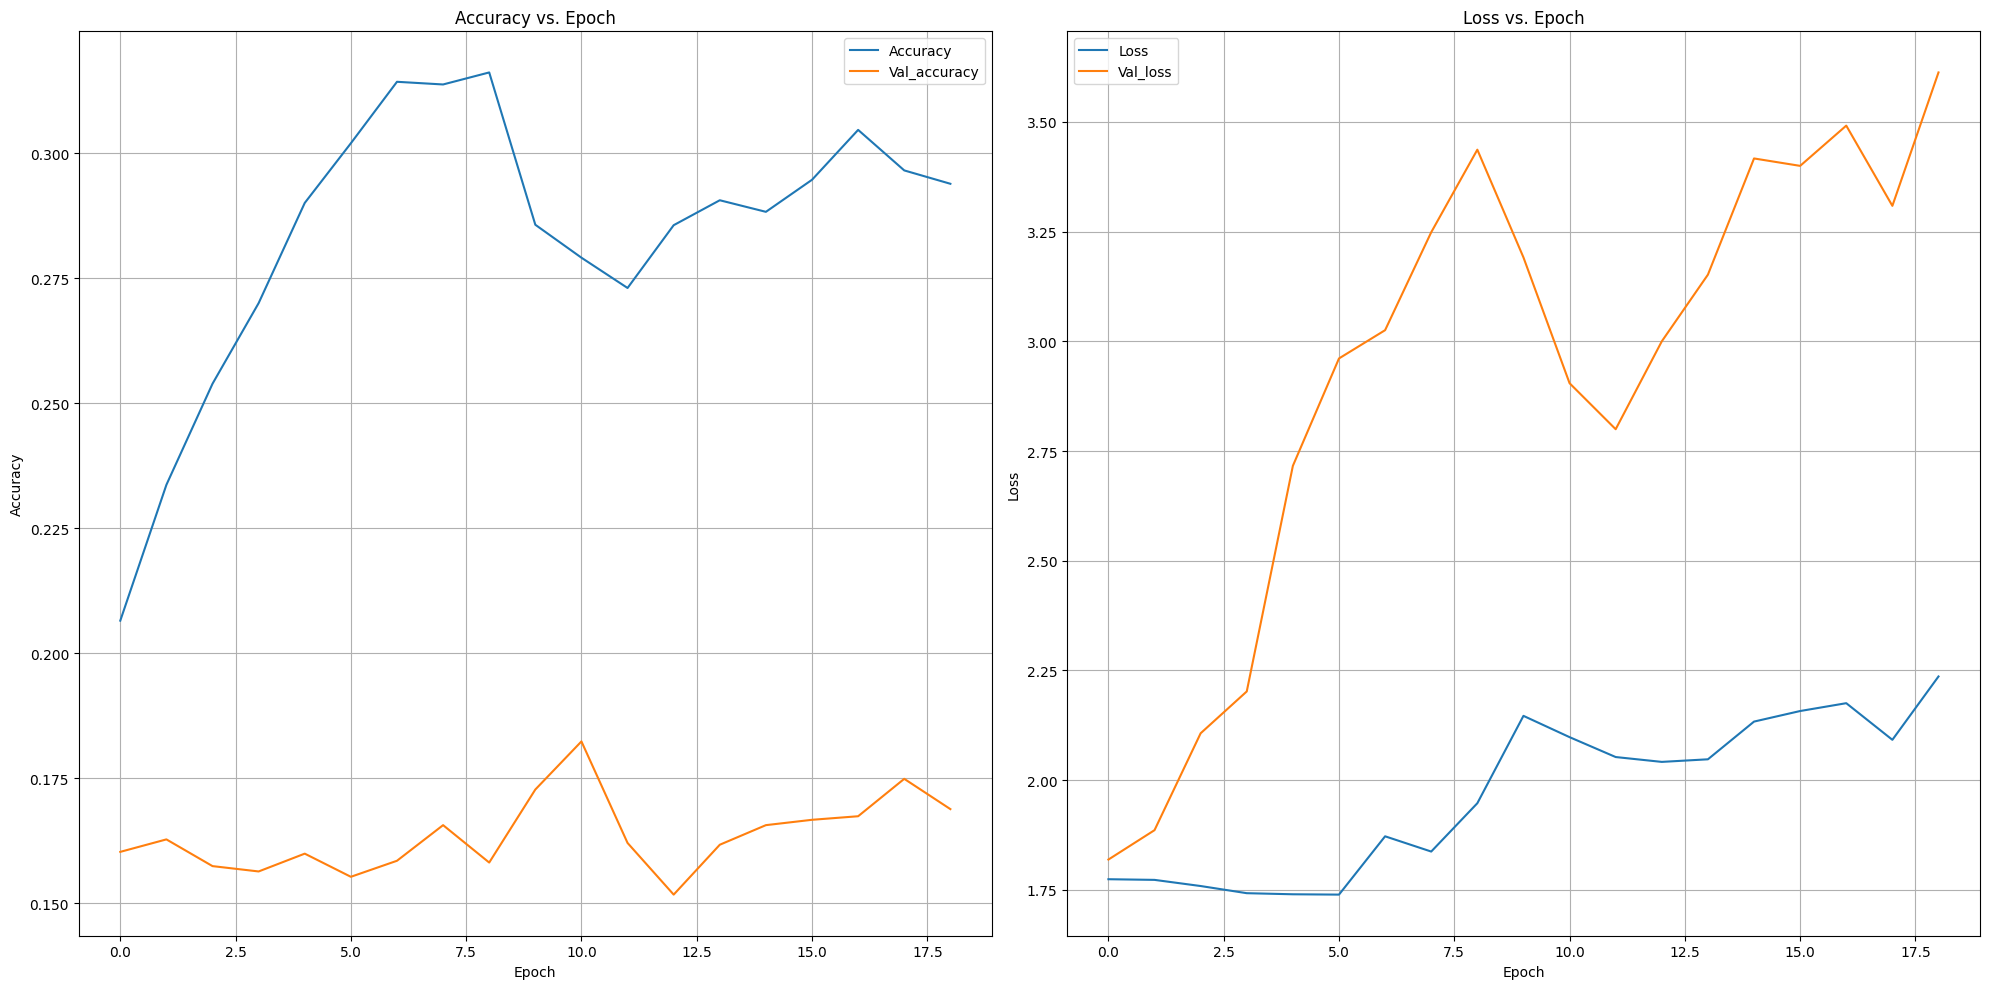

In [51]:
# Graficamos en dos partes
plt.figure(figsize=(20, 10))

# Primera parte: Accuracy
plt.subplot(1, 2, 1)  # 1 fila, 2 columnas, primera subgráfica
plt.plot(resumen['accuracy'], label='Accuracy')  
plt.plot(resumen['val_accuracy'], label='Val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Epoch')
plt.grid(True)
plt.legend()

# Segunda parte: Loss
plt.subplot(1, 2, 2)  # 1 fila, 2 columnas, segunda subgráfica
plt.plot(resumen['loss'], label='Loss')
plt.plot(resumen['val_loss'], label='Val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs. Epoch')
plt.grid(True)
plt.legend()

plt.tight_layout()  # Ajusta automáticamente la disposición de las subgráficas para evitar superposiciones
plt.show()

In [ ]:
# Evaluación contra el conjunto de prueba
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print("Test Accuracy:", test_accuracy)

In [ ]:
# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


In [ ]:
# Reporte de clasificación
print("Classification Report:")
print(classification_report(y_test, y_pred_classes))

In [ ]:
# Matriz de confusión
cm = confusion_matrix(y_test, y_pred_classes)

In [ ]:
# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

## 4 Parte